In [7]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from ..torch_DE.continuous.DE_module import DE_Getter
from ..torch_DE.continuous.Networks import *


def MSE(x:torch.tensor):
    return x.pow(2).mean()




SyntaxError: invalid syntax (3614708888.py, line 4)

# Spring Equation

For our first example lets solve a simple ODE $$ \dfrac{d^2u}{dt^2} = -u(t) ,\quad 0 \leq u \leq 2\pi $$ with initial conditions $u(0)=0$ and $\dfrac{du}{dt} = 1$. This is the famous spring equation and has the solution: $$u(t) = sin(t)$$.

Suppose we don't know the actual solution (in more complicated equations we really don't know!) but know the ODE. Then we want to create and train a network $u_{net}(t)$ that can approximate $u(t)$
$$u_{net}(t)\approx u(t)$$ 
For Torch DE, we need to define 3 things: set up the DE_getter object, generate the some data points and finally create the training loop. If you are familar with pytorch, you'll notice that all of the syntax is very familiar!

## Data Generation

So first thing to do is to generate the data, For this example we can simply generate a 1000 random points between 0 and  $2\pi$. We also need to specifically create a point at t = 0. In this example the initial conditions serve to act as our 'data' while all the other points are called collocation points. Collocation points are points where we don't have any data for but expect to follow a certain equation (in this case we expect these point to follow the above spring equation)

In [3]:
# Collocation Points (From 0 to 2pi)
t_col = torch.rand((998,1))*2*torch.pi

# Initial conditions u(0) = 0 , u_t(0) = 1
t_data = torch.tensor([0]).unsqueeze(-1)

t = torch.cat([t_data,t_col])

print(t.shape)

torch.Size([999, 1])


## Network Creation and DE_Getter

For this simple model, we'll just use a one hidden layer network with a tanh function. ReLu won't work here as well be needing the second derivative (second derivative of Relu is 0 everywhere)

Next we can set up the DE Getter. All we need to do is to choose the variable names of our input and outputs and the derivatives to call. The derivatives use the subscript notation with the underscore indicating the subscript. For example the string 'u_tt' is requesting the second derivative of u with respect to t

u_tt $\equiv u_{tt} \equiv \dfrac{d^2u}{dt^2} $


Note that currently input varibles can only be single characters.

In [ ]:
net = nn.Sequential(nn.Linear(1,200),nn.Tanh(),nn.Linear(200,1))
# Spring Equation

PINN = DE_Getter(net = net)
PINN.set_vars(input_vars= ['t'], output_vars= ['u'])
PINN.set_derivatives(derivatives=['u_t','u_tt'])



## Training Loop
If you have used Pytorch before, youll notice that the training loop looks very similar! The big difference is that instead of calling the network, we call the DE_Getter.calculate method. This will extract all the derivatives for us and put it into a nice dictionary format so we can easily access the derivatives. If we didn't, then we'd be doing some annoying indexing method

For PINN training theres 2 types of losses to be calculated. The first is the data fitting. This is fitting the network to any sort of data, initial condition or boundary conditions. We use the standard Mean Square error to fit these known points
$$Loss_{data} = \sum_i^M (u_{net}(t_i) - u_{data}(t_i))^2 + \sum_i^N \biggl[\dfrac{du_{net}}{dt_i} - \dfrac{du_{data}}{dt_i}\biggr]^2 $$

The second loss is the equation itself. Moving eveything to the left hand side:
$$\dfrac{d^2u}{dt^2}+u(t) = 0 $$

Ideally, when we calculate the above with our network $u_{net}$ the above equation is close to 0, however intially this is not the case and the LHS is some non zero function:
$$\dfrac{d^2u_{net}}{dt^2}+u_{net}(t) = R(t) $$ 

We call R(t) the residual function. We want to minimise this value, as this will mean that our network is then following this equation correctly in our domain. Minimisation is also done with mean square error
$$Loss_{Reisdual} = \sum_i^n (\dfrac{d^2u_{net}}{dt_i^2}+u_{net}(t_i))^2 $$

So the total Loss is:
$$Loss = Loss_{data} + Loss_{Residual}$$


For the optimizer well use Adam and a lr of 1e-3 and train for 5000 Epochs. Don't worry this run in a few min on just the CPU!

In [ ]:
optimizer = torch.optim.Adam(params = net.parameters(), lr = 1e-3)

# For Loop
for i in range(5000):
    #Calculate Derivatives
    out = PINN.calculate(t)

    #Spring Equation is u_tt + u = 0. Notice we can easily call derivatives and outputs by strings rather than having to do
    #indexing
    residual = (out['u_tt'] + out['u']).pow(2).mean()

    #Data Fitting. In this case we know that the first element is the point t=0
    data = out['u'][0].pow(2).mean() + (out['u_t'][0] - 1).pow(2).mean()


    loss = data + residual
    print(f'Epoch {i} Total Loss{float(loss)}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## Plotting Spring Equation

We can then plot the results and compare with the analytical solution.

In [4]:
from matplotlib import pyplot as plt

def torch_line_plot(x:torch.tensor,y:torch.tensor,*args,return_vars:bool=False,plot_func:bool = True ,**kwargs):
    '''
    Just a more convient way of plotting using matplotlib ploting function for Pytorch networks
    
    x = input to network. torch.tensor of shape (B,1) where B is batch size.
    y = output of network.  torch.tensor of shape (B,1) where B is batch size.
    return_vars: Whether to return the cleaned x and y for further plotting, Default False
    plot_func: Whether to plot the function of (x,y(x)), Default True

    *args and **kwargs are any parameters to pass into matplotlib.pyplot's plot function
    '''

    x_in = x.to('cpu').squeeze().detach().numpy()
    y_in = y.to('cpu').squeeze().detach().numpy()

    print(x_in.shape,y_in.shape)
    if plot_func:
        plt.plot(x_in,y_in,*args,**kwargs)

    if return_vars is True:
        return x_in,y_in

torch.Size([100, 1]) torch.Size([100, 1])
(100,) (100,)
(100,) (100,)


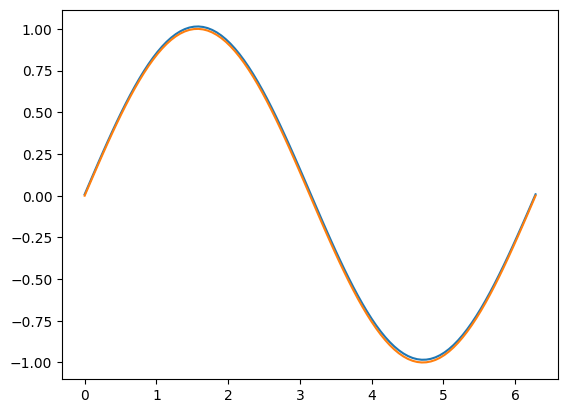

In [67]:
from matplotlib import pyplot as plt


x = torch.linspace(0,2*torch.pi,100).unsqueeze(dim = -1)
y = net(x)

y_pred = torch.sin(x)
print(x.shape,y.shape)
torch_line_plot(x,y)
torch_line_plot(x,y_pred)

Looks pretty good right!

# 1D Heat Equation
Lets move on to something a bit more difficult the Heat equation. This is a partial differential equation (PDE) as the heat u depends on both space and time.
$$$$

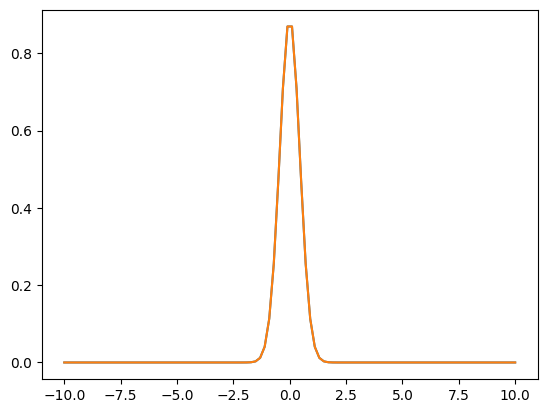

In [21]:
#Heat Equation
#Thermal Diffusivity
k = 1

# x points
x = torch.linspace(-10,10,100)
t = torch.linspace(0.1,10,50)

#Generate all (x,t) points above this is |x|*|t| number of points so 100**2 = 10,000 points

x_g,t_g = torch.meshgrid([x,t])

#Flatten the grid into a single line tensor and then stack to form a [10000,2] tensor

x_f,t_f = x_g.flatten(),t_g.flatten()

points = torch.stack([x_f,t_f],dim = -1)

#Initial Conditions is at t= 0.1
IC_x = points[points[:,-1] == t[0]][:,0]
IC = 1/torch.sqrt(4*torch.pi*k*t[0])*torch.exp(-IC_x**2 /(4*k*t[0]))

#Show IC solution (No extra dims so can use normal plt.plot)
plt.plot(x,IC)
norm = lambda x,t : 1/torch.sqrt(4*torch.pi*k*t)*torch.exp(-x**2/(4*k*t))

plt.plot(x,norm(x,torch.tensor([0.1])))

In [11]:

device = 'cpu'
net = nn.Sequential(nn.Linear(2,200),nn.Tanh(),nn.Linear(200,1))

PINN = DE_Getter(net = net)
PINN.set_vars(input_vars= ['x','t'], output_vars= ['u'])
PINN.set_derivatives(derivatives=['u_t','u_xx'])


optimizer = torch.optim.Adam(params = net.parameters(), lr = 1e-3)
net = net.to(device=device)
# For Loop
for i in range(10000):
    out = PINN.calculate(points.to(device))
    #Spring Equation is u_tt + u = 0
    residual = (k*out['u_xx'] - out['u_t']).pow(2).mean()

    #Data Fitting or in this case IC
    data = (out['u'][points[:,-1] == t[0]] - IC.to(device)).pow(2).mean()

    loss = data + residual
    print(f'Epoch {i} Total Loss{float(loss)}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch 0 Total Loss0.15102127194404602
Epoch 1 Total Loss0.08443997800350189
Epoch 2 Total Loss0.06459305435419083
Epoch 3 Total Loss0.07230255752801895
Epoch 4 Total Loss0.07947544753551483
Epoch 5 Total Loss0.07481079548597336
Epoch 6 Total Loss0.062062330543994904
Epoch 7 Total Loss0.04848145693540573
Epoch 8 Total Loss0.03947000950574875
Epoch 9 Total Loss0.03681806102395058
Epoch 10 Total Loss0.03864830732345581
Epoch 11 Total Loss0.04113152250647545
Epoch 12 Total Loss0.04121427237987518
Epoch 13 Total Loss0.03825676068663597
Epoch 14 Total Loss0.03369585797190666
Epoch 15 Total Loss0.029688149690628052
Epoch 16 Total Loss0.027800990268588066
Epoch 17 Total Loss0.028263654559850693
Epoch 18 Total Loss0.03000842221081257
Epoch 19 Total Loss0.03145362436771393
Epoch 20 Total Loss0.03151015564799309
Epoch 21 Total Loss0.03012021817266941
Epoch 22 Total Loss0.02807609736919403
Epoch 23 Total Loss0.026397360488772392
Epoch 24 Total Loss0.02570393495261669
Epoch 25 Total Loss0.025913605

In [13]:
torch.save(net.state_dict(),'net_weights.pth')

In [3]:
net = nn.Sequential(nn.Linear(2,200),nn.Tanh(),nn.Linear(200,1))
net.load_state_dict(torch.load('net_weights.pth'))

<All keys matched successfully>

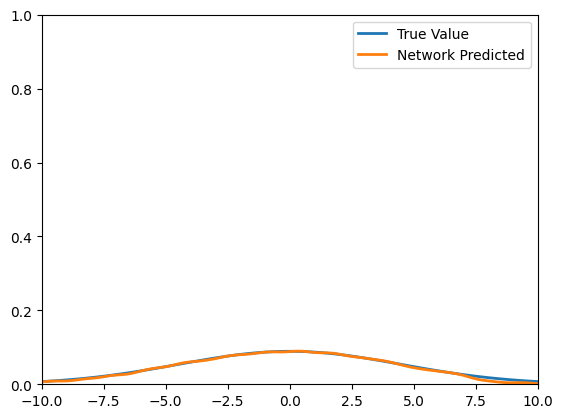

In [23]:
from torch import tensor
import matplotlib.pyplot as plt
import matplotlib.animation as animation
fig = plt.figure()
axis = plt.axes(xlim =(-10, 10),
				ylim =(0, 1))

line, = axis.plot([], [], lw = 2,label = 'True Value')
line2, = axis.plot([], [], lw = 2,label = 'Network Predicted')
k=1

def init():
	line.set_data([], [])
	return line,

# initializing empty values
# for x and y co-ordinates
xdata, ydata = [], []
norm = lambda x,t : 1/torch.sqrt(4*torch.pi*k*t)*torch.exp(-x**2/(4*k*t))


plt.legend()
# animation function
def animate(i):
    x = torch.linspace(-10, 10, 100)
    t = tensor([i*0.1 + 0.1])
    y_true = norm(x,t)  # Update the y-values based on the frame number
    
    t_net = torch.ones_like(x)*t

    points = torch.stack([x,t_net],dim = -1)
    y_pred = net(points)

    line.set_data(x,y_true)
    line2.set_data(x,y_pred.detach().squeeze())
    return (line,line2)
	

# calling the animation function	
anim = animation.FuncAnimation(fig, animate,
							init_func = init,
							frames = 100,
							interval = 20,
							blit = True)

# saves the animation in our desktop
anim.save('Heat_Equation.mp4', writer = 'ffmpeg', fps = 10)

# 2D Heat Equation

This example shows how to use Torch DE with the GPU on the 2D Heat Equation  $$k\nabla^2 u = {\partial u \over \partial t} $$

Where $\nabla^2 u = \dfrac{\partial^2 u}{\partial x^2} + \dfrac{\partial^2 u}{\partial y^2}$

With a point source, the solution is: $$ u(x,y,t) = \dfrac{1}{(4\pi kt)}e^{\dfrac{-||x-y||^2}{4kt}} $$

## Generate the Data

In [2]:
def u(xyt,k=1):
    x,y,t = torch.moveaxis(xyt,0,-1)
    return 1/(4*torch.pi*k*t)*torch.exp(-(x.pow(2)+y.pow(2))/(4*k*t))
    

In [3]:
x,y = [torch.linspace(-5,5,50) for _ in range(2)]
t = torch.linspace(0.1,10,50)

flat_grid = [f.flatten() for f in torch.meshgrid([x,y,t])]

all_points = torch.stack(flat_grid,dim = -1)
all_points.shape

IC_mask = all_points[:,-1] == t[0]

IC_points = all_points[IC_mask]
IC_data = u(IC_points)
Col_points = all_points[~IC_mask]

all_points.shape,IC_points.shape,Col_points.shape

C:\Users\John Su\AppData\Roaming\Python\Python39\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(torch.Size([125000, 3]), torch.Size([2500, 3]), torch.Size([122500, 3]))

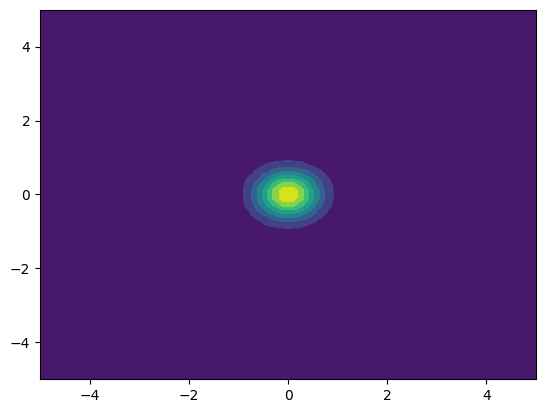

In [4]:
plt.tricontourf(IC_points[:,0],IC_points[:,1],IC_data)

In [5]:
IC_DL = DataLoader(IC_points,batch_size = 2500//10 )
Col_DL = DataLoader(Col_points,batch_size= Col_points.shape[0]//10)

## Using Regular PyTorch

In [6]:
from Networks import MLP
net = MLP(3,3,200,3,'sin')
PINN = DE_Getter(net = net)
PINN.set_vars(input_vars= ['x','y','t'], output_vars= ['u'])
derivs = ['u_t','u_xx','u_yy']
PINN.set_derivatives(derivatives=derivs)
group_names = ['IC','Collocation']

In [38]:
optimizer = torch.optim.Adam(net.parameters(),lr=1e-3)
net = net.cuda()
for epoch in range(10000):
    running_loss = 0
    for data_tuple in zip(IC_DL,Col_DL):
        optimizer.zero_grad()
        IC_xyt = data_tuple[0]
        group_sizes = [data.shape[0] for data in data_tuple]
        
        x = torch.cat(data_tuple,dim = 0).cuda()
        out = PINN.calculate(x,group_names,group_sizes)

        #Losses
        l1 = MSE(out['IC']['u'] - u(IC_xyt.cuda()))

        u_t,u_xx = out['Collocation']['u_t'], out['Collocation']['u_xx']
        l2 = MSE(u_t-u_xx)

        loss = l1+l2
        loss.backward()
        optimizer.step()
        running_loss += loss
    
    print(f'Loss for Epoch {epoch}: {running_loss}')

        


Loss for Epoch 0: 0.1880396157503128
Loss for Epoch 1: 0.08470423519611359
Loss for Epoch 2: 0.1764725148677826
Loss for Epoch 3: 0.20171284675598145
Loss for Epoch 4: 0.12274418771266937
Loss for Epoch 5: 0.14529986679553986
Loss for Epoch 6: 0.12706215679645538
Loss for Epoch 7: 0.21775823831558228
Loss for Epoch 8: 0.083236463367939
Loss for Epoch 9: 0.12493608891963959
Loss for Epoch 10: 0.0934673473238945
Loss for Epoch 11: 0.0558558814227581
Loss for Epoch 12: 0.05317372828722
Loss for Epoch 13: 0.046380069106817245
Loss for Epoch 14: 0.038287337869405746
Loss for Epoch 15: 0.04118095710873604
Loss for Epoch 16: 0.03752240911126137
Loss for Epoch 17: 0.033709749579429626
Loss for Epoch 18: 0.033290375024080276
Loss for Epoch 19: 0.03287503495812416
Loss for Epoch 20: 0.0326722152531147
Loss for Epoch 21: 0.032586801797151566
Loss for Epoch 22: 0.03240438550710678
Loss for Epoch 23: 0.03227894753217697
Loss for Epoch 24: 0.03216079995036125
Loss for Epoch 25: 0.03198114037513733
L

KeyboardInterrupt: 

## Setting it up with Pytorch Lightning!

We can also set this up with Pytorch Lightning for reduced boilerplate code. AS the domain gets more complicated with more boundary and initial conditions and data, it can get difficult to manage all the code. Pytorch Lightning is a great framework that helps keeps all the boilerplate down. It also interoperates with tensorboard, WandB (My personal favourite) loggers allowing an easy way to keep track of runs and results.


Firstly well need to encapsulate all the different dataloaders into one object that can be iterated on

In [6]:
class CombinedDataloader():
    def __init__(self, *dataloaders):
        self.dataloaders = dataloaders
    def __iter__(self):
        for data in zip(*self.dataloaders):
            yield data


In [7]:
def combined_dataloader(datasets,num_iters,**kwargs):
    '''
    Given a list of datasets create an iterater that functions as a combined dataloader. The dataloader is such that the number of iteration i.e. length of each
    individual dataloader is the same.

    **kwargs any keyword arguements to pass to dataloaders. The keyword is applied to all dataloaders

    '''
    DLs = []
    for dataset in datasets:
        bs = len(dataset)//num_iters
        DL = DataLoader(dataset,batch_size=bs,**kwargs)
        DLs.append(DL)
    return CombinedDataloader(DLs)

For lightning, the training loop is tied to the module itself, so we have to add the DE_getter class as an attribute rather than have it outside of the network. In this case we pass the self object or self.net into DE_getter.

In [8]:
import pytorch_lightning as pl
class Heat_equation_2D(pl.LightningModule):
    def __init__(self, net : nn.Module,group_names = None) -> None:
        super().__init__()
        self.net = net
        self.PINN = DE_Getter(net = self)
        self.group_names = group_names
    
    def forward(self,x):
        return net(x)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(),lr = 1e-3)
    
    def training_step(self, train_batch, batch_idx):
        IC_xyt = train_batch[0]
        group_sizes = [data.shape[0] for data in train_batch]
        
        x = torch.cat(train_batch,dim = 0).cuda()
        out = PINN.calculate(x,self.group_names,group_sizes)

        #Losses
        l1 = MSE(out['IC']['u'] - u(IC_xyt.cuda()))

        u_t,u_xx = out['Collocation']['u_t'], out['Collocation']['u_xx']
        l2 = MSE(u_t-u_xx)

        loss = l1+l2

        #Log Losses
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True,reduce_fx=torch.sum)
        return loss



C:\Users\John Su\AppData\Roaming\Python\Python39\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [9]:
def silu(x):
    return x*torch.sigmoid(x)

In [10]:
from Networks import *
net = MLP(3,1,200,5,'sin')
net = Fourier_Net(3,1,200,4,100)
net = Modified_Fourier_Net(3,1,200,3,100,activation=silu,adaptive_activation=True)
model = Heat_equation_2D(net)
PINN = model.PINN
PINN.set_vars(input_vars= ['x','y','t'], output_vars= ['u'])
derivs = ['u_t','u_xx','u_yy']
PINN.set_derivatives(derivatives=derivs)
model.group_names = ['IC','Collocation']


In [11]:
IC_DL = DataLoader(IC_points,batch_size = 2500//10 )
Col_DL = DataLoader(Col_points,batch_size= Col_points.shape[0]//10)
data = CombinedDataloader(IC_DL,Col_DL)
# data.set_num_iters(20)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                 | Params
----------------------------------------------
0 | net  | Modified_Fourier_Net | 162 K 
----------------------------------------------
162 K     Trainable params
0         Non-trainable params
162 K     Total params
0.649     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


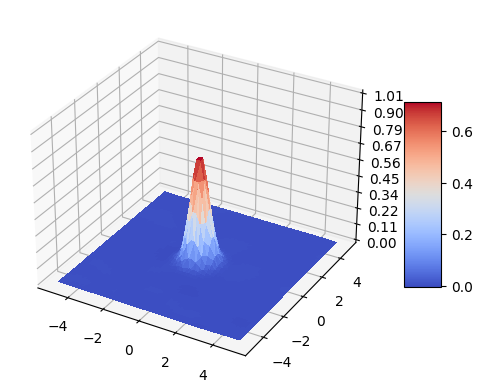

In [12]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
xp,yp =  [IC_points[:,i] for i in range(2)]
# Plot the surface.
with torch.no_grad():
    u = net(IC_points).to('cpu').squeeze()


surf = ax.plot_trisurf(xp, yp, u, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# 2D Navier Stokes

In [3]:
#Cylinder

D = 1

x_interval = (-4,10)
y_interval = (-3,3)

x = torch.linspace(*x_interval,250)
y = torch.linspace(*y_interval,250)
t = torch.linspace(0,10,50)

def generate_points_from_grid(*args):
    grid = torch.meshgrid(args)
    flat_grid = [g.flatten() for g in grid]
    return torch.stack(flat_grid,dim = -1)

points = generate_points_from_grid(x,y,t)


# Exclude points that are within the cylinder

cylinder_mask = (points[:,0]**2 + points[:,1]**2) >= 0.5**2

# Exclude Initial Conditions
IC_mask = points[:,-1] > t[0]

points.shape

C:\Users\John Su\AppData\Roaming\Python\Python39\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([3125000, 3])

In [4]:
overall_mask = torch.logical_or(cylinder_mask,IC_mask)
points2 = points[overall_mask]
points2.shape

torch.Size([3124422, 3])

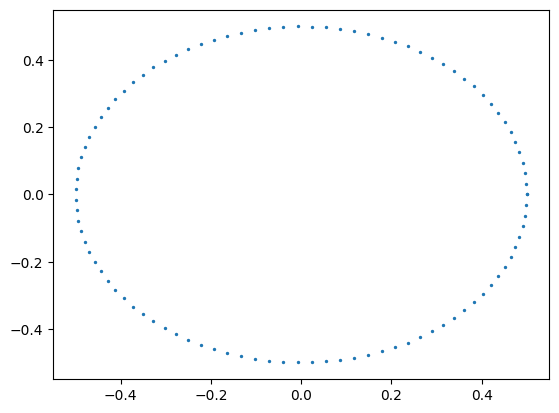

In [5]:
# Initial Conditions
#inlet Flow at x_min is set to 1
#Lets just create a new set of data

inlet_y = torch.linspace(*y_interval,50)
inlet_x = torch.ones_like(inlet_y)*x_interval[0]
inlet_t = torch.zeros_like(inlet_y)


inlet = torch.stack([inlet_x,inlet_y,inlet_t],dim = -1)

def generate_conditions(*args,t = None):
    '''
    Generate points for time independent conditions across a tensor of timepoint t. 
    Useful if you have generated points representing boundary conditions that do not change over time
    
    *args: Each arguement should be a 1D sized tensor of sized N2. Typically points expressed as x,y,z
    t: a 1D tensor of size N
    note that the time tensor can be different to that of args

    '''

    shape = args[0].shape
    for a in args:
        assert a.shape == shape

    t0 = torch.ones(shape)*t[0]
    BC = torch.stack(args+(t0,),dim = -1)
    for t_point in t[1:]:
        next_t_point = torch.ones(shape)*t_point
        BC = torch.cat([BC,torch.stack(args + (next_t_point,),dim = -1)],dim= 0)
    return BC


inlet = generate_conditions(inlet_x,inlet_y,t = torch.linspace(0,10,50))
inlet_u = 1
inlet_v = 0

theta = torch.linspace(0,2*torch.pi,100) 
cylinder_x = D/2*torch.cos(theta)
cylinder_y = D/2*torch.sin(theta)

cylinder = generate_conditions(cylinder_x,cylinder_y,t = torch.linspace(0,10,50))

plt.scatter(cylinder_x,cylinder_y,s=2)


In [6]:

a =torch.logical_and(cylinder_mask,~IC_mask)
IC = points[a]
IC.shape
inlet_mask =IC[:,0] == x[0]
IC = IC[~inlet_mask]
#Set IC to u = 1, v = 0 with ~10% vairation
IC_u = 2/10*(torch.rand(IC.shape)-0.5)+1
IC_v = 2/10*(torch.rand(IC.shape)-0.5)


In [7]:
def navierStokes2D(out,Re):
    #Really shouldnt do this buy lasy af
    return (out['u_t'] + out['u_x']*out['u']+ out['u_y']*out['v'] +out['p_x'] - 1/Re*(out['u_xx']+out['u_yy']),
            out['v_t'] + out['v_x']*out['u']+ out['v_y']*out['v'] +out['p_y'] - 1/Re*(out['v_xx']+out['v_yy']) )


def incompressibility(out):
    return out['u_x']+out['v_y']
Re = 100

In [8]:
IC.shape,inlet.shape,cylinder.shape,points2.shape

(torch.Size([61672, 3]),
 torch.Size([2500, 3]),
 torch.Size([5000, 3]),
 torch.Size([3124422, 3]))

In [9]:
from Networks import MLP

In [14]:
# net = nn.Sequential(nn.Linear(3,200),nn.Tanh(),nn.Linear(200,200),nn.Tanh(),nn.Linear(200,3))
net = MLP(3,3,200,3,'sin')


PINN = DE_Getter(net = net)
PINN.set_vars(input_vars= ['x','y','t'], output_vars= ['u','v','p'])

derivs = ['u_x','u_y','u_t','u_xx','u_yy',
          'v_x','v_y','v_t','v_xx','v_yy',
          'p_x','p_y'
          ]
PINN.set_derivatives(derivatives=derivs)

def MSE(x:torch.tensor):
    return x.pow(2).mean()

col_bs = 9000
num_iters = points2.shape[0]//col_bs
num_iters = 10 
IC_DL = DL(IC,batch_size=IC.shape[0]//num_iters)
Inlet_DL = DL(inlet,batch_size= inlet.shape[0]//num_iters)
Cyl_DL = DL(cylinder,batch_size=cylinder.shape[0]//num_iters)
Col_DL = DL(points2,batch_size=col_bs)




PINN.net = PINN.net.cuda()
optimizer = torch.optim.Adam(params = net.parameters(), lr = 1e-3)
# optimizer = torch.optim.LBFGS(params = net.parameters(),lr = 1)

group_names = ['IC','Inlet','Cylinder','Collocation']

for i in range(1000):
    running_loss = 0
    for data in zip(IC_DL,Inlet_DL,Cyl_DL):
        optimizer.zero_grad()

        #Data Wrangling
        b_sizes = tuple(d.shape[0] for d in data)
        x = torch.cat(data,dim=0)
        out = PINN.calculate(x.cuda(),groups = group_names,group_sizes= b_sizes)
        
        #Losses

        #IC
        u_IC,v_IC = out['IC']['u'],out['IC']['v']
        l1 = MSE(u_IC-0) + MSE(v_IC-0)
        
        #Inlet
        u_inlet, v_inlet = out['Inlet']['u'],out['Inlet']['v']
        l2 = MSE(u_inlet-1) + MSE(v_inlet-0)
        
        # #Cylinder
        u_cyl, v_cyl = out['Cylinder']['u'],out['Cylinder']['v']
        l3 = MSE(u_cyl) + MSE(v_cyl)
        
        #Col_DL
        # n_x,n_y = navierStokes2D(out['Collocation'],100)
        # incomp = incompressibility(out['Collocation'])
        # l4 = MSE(n_x) + MSE(n_y) + MSE(incomp)
        
        loss = l1+l2+l3#+l4
        # print(l1,l2,l3,l4)
        running_loss +=  loss
        loss.backward()
        optimizer.step()

    print(f'Epoch {i} Total Loss{float(running_loss)}')
    


Epoch 0 Total Loss3.3958141803741455
Epoch 1 Total Loss5.9152140617370605
Epoch 2 Total Loss6.944911956787109
Epoch 3 Total Loss3.2438435554504395
Epoch 4 Total Loss3.8719868659973145
Epoch 5 Total Loss2.7791261672973633
Epoch 6 Total Loss1.7149900197982788
Epoch 7 Total Loss1.4214606285095215
Epoch 8 Total Loss1.1151596307754517
Epoch 9 Total Loss0.9307270646095276
Epoch 10 Total Loss0.7721531987190247
Epoch 11 Total Loss0.6978437900543213
Epoch 12 Total Loss0.5986040234565735
Epoch 13 Total Loss0.596907913684845
Epoch 14 Total Loss0.5307456254959106
Epoch 15 Total Loss0.5572443604469299
Epoch 16 Total Loss0.5251683592796326
Epoch 17 Total Loss0.5597535371780396
Epoch 18 Total Loss0.6478372812271118
Epoch 19 Total Loss0.7380585074424744
Epoch 20 Total Loss0.9083696007728577
Epoch 21 Total Loss0.8216050863265991
Epoch 22 Total Loss0.7100188732147217
Epoch 23 Total Loss0.5622968077659607
Epoch 24 Total Loss0.514371931552887
Epoch 25 Total Loss0.4609817862510681
Epoch 26 Total Loss0.4544

KeyboardInterrupt: 

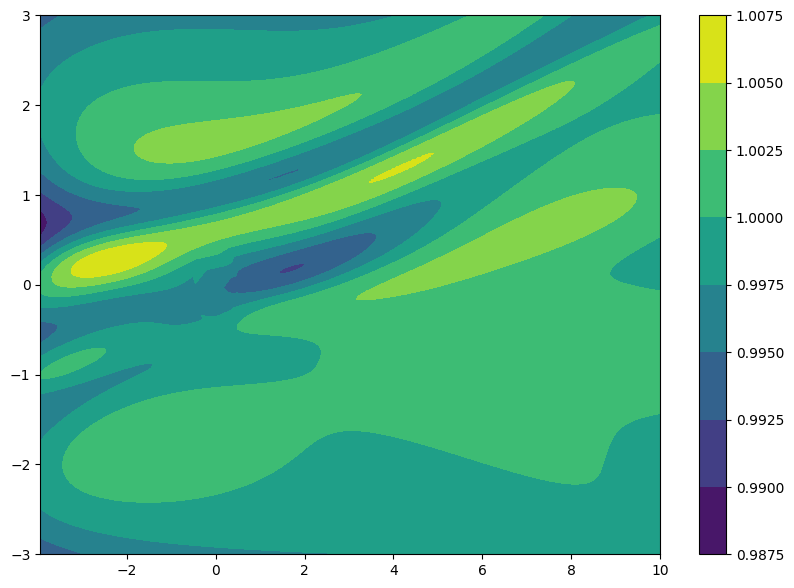

In [66]:

# x = torch.linspace(*x_interval,250)
# y = torch.linspace(*y_interval,250)
# t = torch.zeros(250*250)

# test = generate_points_from_grid(x,y)
# test = torch.stack([test[:,0],test[:,1],t],dim=-1)


output = net.to('cpu')(IC)
u = output[:,0].detach().squeeze()

plt.figure(figsize=(10,7))
contour =plt.tricontourf(IC[:,0],IC[:,1],u)
plt.colorbar(contour)
